In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math
import torch

import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append('../')
from src.data_generator import MRIDataset
from src.utils import get_glioma_indices, plot_tumour

In [2]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

In [3]:
t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))

clicks_dataset = MRIDataset(
    t1_list[2:4], t2_list[2:4], seg_list[2:4],
    (40, 256, 256),
    clicks = {
        'use': True,
        'gen_fg': False,
        'gen_bg': False,
        'gen_border': True,
        'num': 3,
        'dst': 10
    }
)

In [4]:
t1_list[2:4]

['../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz',
 '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz']

In [5]:
img, label = clicks_dataset[0]
# click_label = click_label[1].unsqueeze(0)

Tumour indices:  11 27


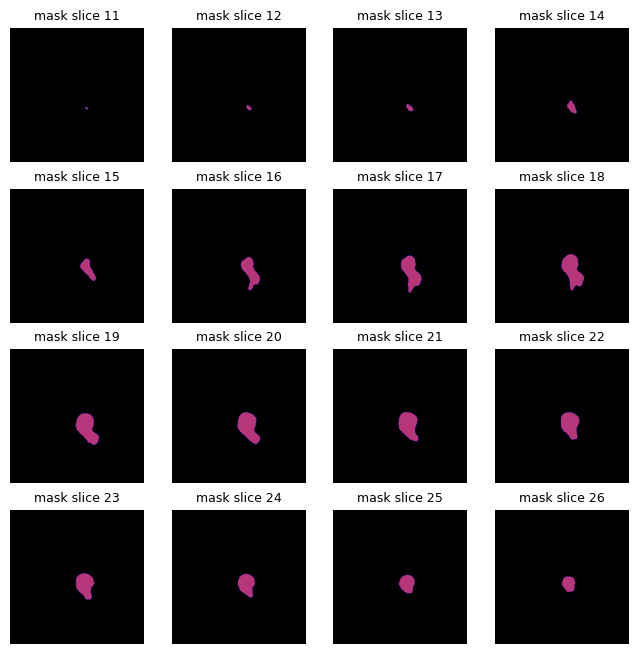

In [6]:
plot_tumour(label[0].unsqueeze(0) + label[1].unsqueeze(0))

In [7]:
click_coords = torch.nonzero(label[1])
click_coords[:10]

tensor([[ 11, 151, 144],
        [ 12, 151, 143],
        [ 13, 146, 142],
        [ 13, 155, 153],
        [ 14, 150, 152],
        [ 14, 158, 144],
        [ 14, 160, 155],
        [ 15, 133, 145],
        [ 15, 149, 135],
        [ 15, 153, 155]])

In [8]:
click_coords[0]

tensor([ 11, 151, 144])

torch.Size([40, 40])


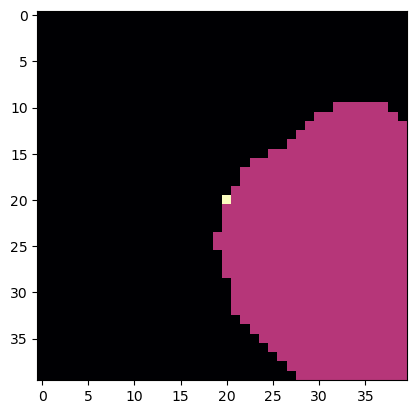

In [9]:
click_idx = 10
cut_size = 20
coords = click_coords[click_idx]

# print((coords[1]-cut_size, coords[1]+cut_size))
# print((coords[2]-cut_size, coords[2]+cut_size))

click = torch.zeros_like(label[0, coords[0]])
click[coords[1], coords[2]] = 1

a = label[0, coords[0]] + click
cut = a[
    coords[1]-cut_size:coords[1]+cut_size,
    coords[2]-cut_size:coords[2]+cut_size
]
print(cut.shape)
plt.imshow(cut, cmap='magma')

### Cuts

In [10]:
from random import shuffle

In [11]:
def cut_volume(label: torch.Tensor, cut_size=32, num=12, random=False):
    cut_size = cut_size // 2 # needed only as a distance from the center
    
    click_coords = torch.nonzero(label[1])
    # randomize cuts
    if random:
        click_coords = click_coords[torch.randperm(len(click_coords))]
    
    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        click = torch.zeros_like(label[0][coords[0]])
        click[coords[1], coords[2]] = 1

        # a = label[0][coords[0]] + click
        cut = torch.clone(label[0][coords[0]])
        # a[coords[1], coords[2]] = 2
        cut = cut[
            coords[1]-cut_size:coords[1]+cut_size,
            coords[2]-cut_size:coords[2]+cut_size
        ]
        cuts.append(cut)
    
    return cuts, click_coords

In [24]:
def plot_cuts(cuts: list[torch.Tensor], cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
        tmp_cut = torch.clone(cut)
        tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

In [13]:
def plot_cut(cut, cmap='magma'):
    tmp_cut = torch.clone(cut)
    tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
    plt.imshow(tmp_cut, cmap=cmap)

In [14]:
label.shape

torch.Size([2, 40, 256, 256])

torch.Size([32, 32])

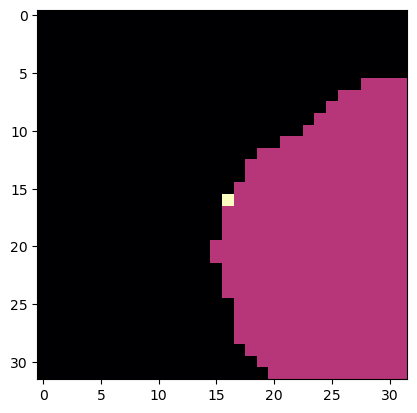

In [15]:
cuts, clicks = cut_volume(label, cut_size=32, num=24)
plot_cut(cuts[10], cmap='magma')
cuts[0].shape

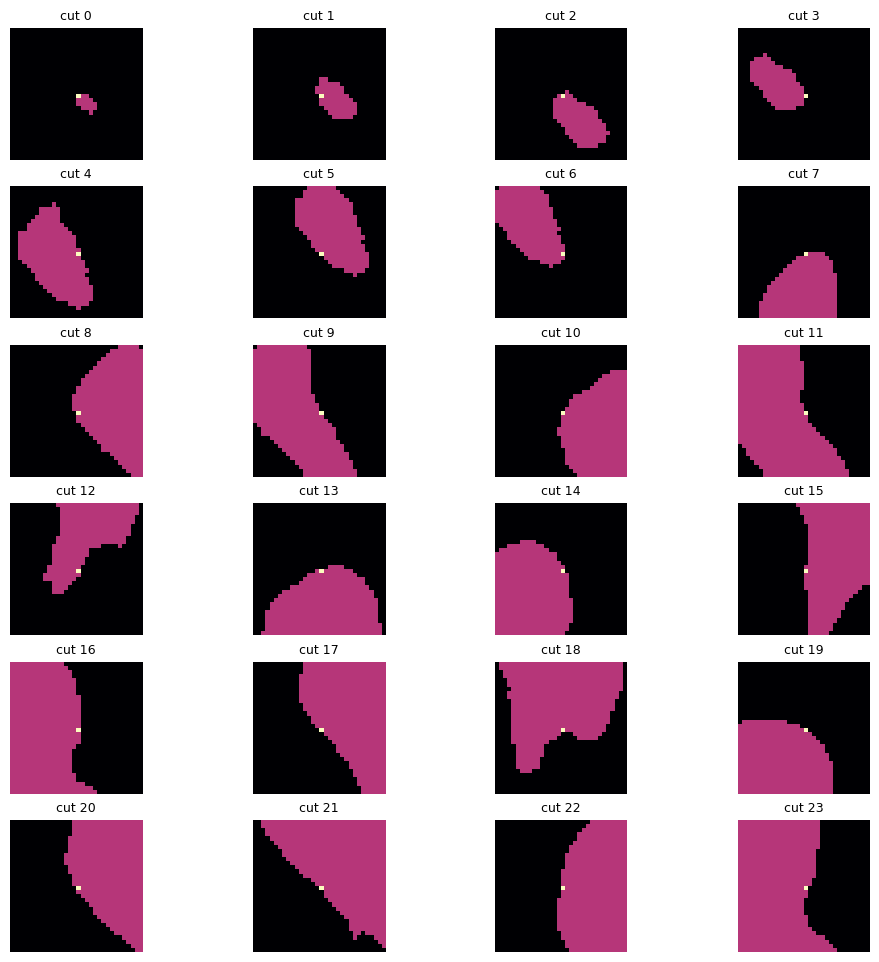

In [16]:
plot_cuts(cuts)

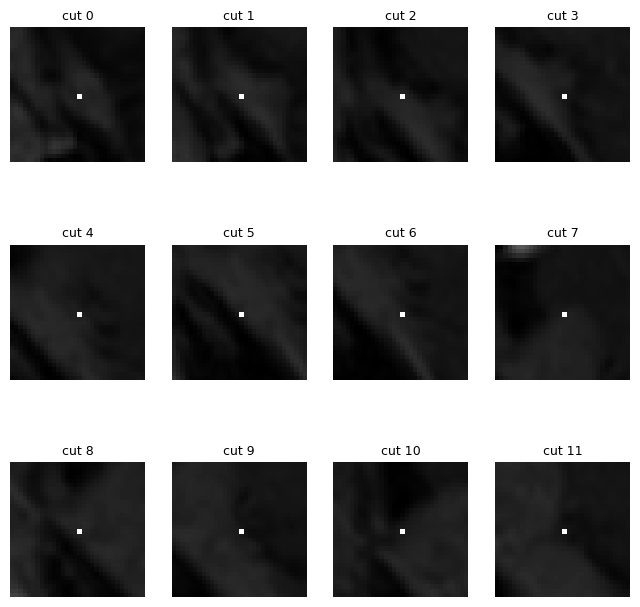

In [17]:
img[1] = label[1]
plot_cuts(cut_volume(img, cut_size=32, num=12)[0], cmap='grey')

In [71]:
cuts, clicks = cut_volume(label, cut_size=32, num=24)
clicks[10]

tensor([ 15, 175, 159])

In [73]:
tmp_cut = torch.clone(cuts[10])
tmp_cut[cuts[0].shape[0]//2, cuts[0].shape[0]//2] = 2
fig = px.imshow(tmp_cut)
fig.show()

### Simulating segmentation errors

In [82]:
from copy import deepcopy
import cv2

#### 1st try

In [79]:
# TODO: prepisat na diletaciu / eroziu

def simulate_errors(cuts: list[torch.Tensor]):
    faked_cuts = deepcopy(cuts)
    for cut in faked_cuts:
        width = cut.shape[0]
        heigth = cut.shape[1]

        pp = np.random.uniform(low=0.0, high=1.0)

        for x in range(width):
            for y in range(heigth):
                dst = np.linalg.norm([width//2 - x, heigth//2 - y]) 
                p = (dst/(heigth//2)) ** 2
                # print(p, dst)
                
                if 0.5 > pp:
                    if cut[x, y] == 1:
                        if p < np.random.uniform(low=0.0, high=0.6):
                            cut[x, y] = 0

                elif cut[x, y] == 0:
                    if p < np.random.uniform(low=0.0, high=0.6):
                        cut[x, y] = 1
    

    return faked_cuts

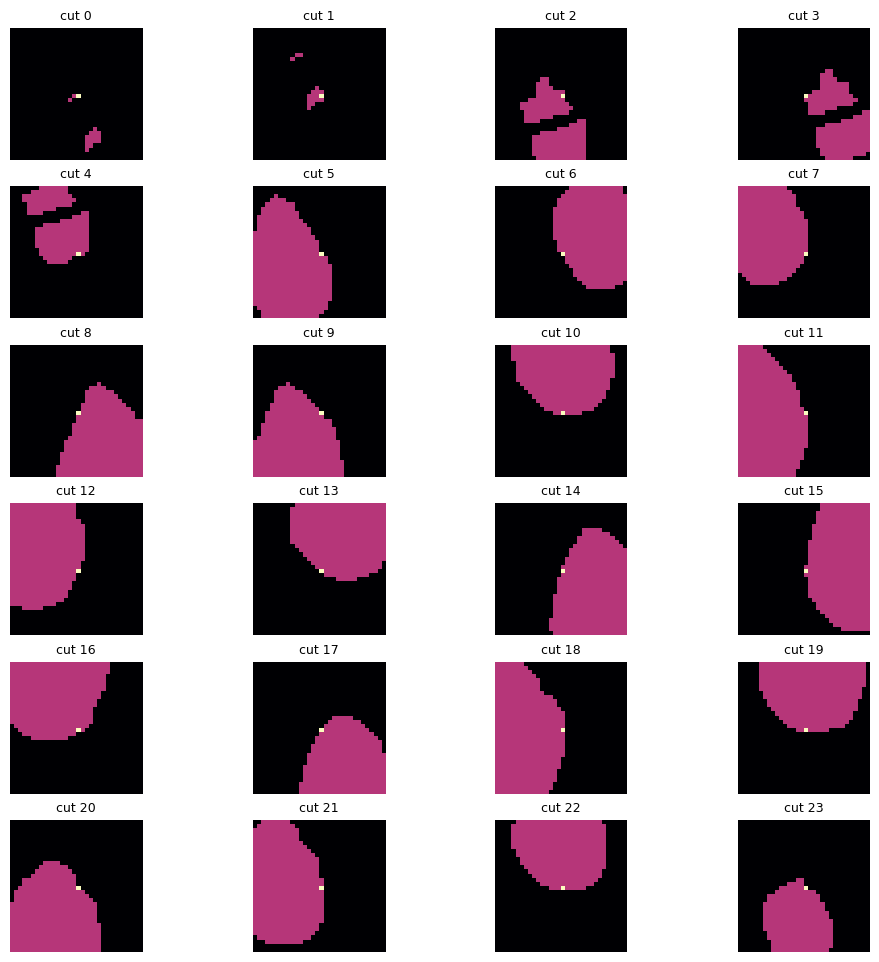

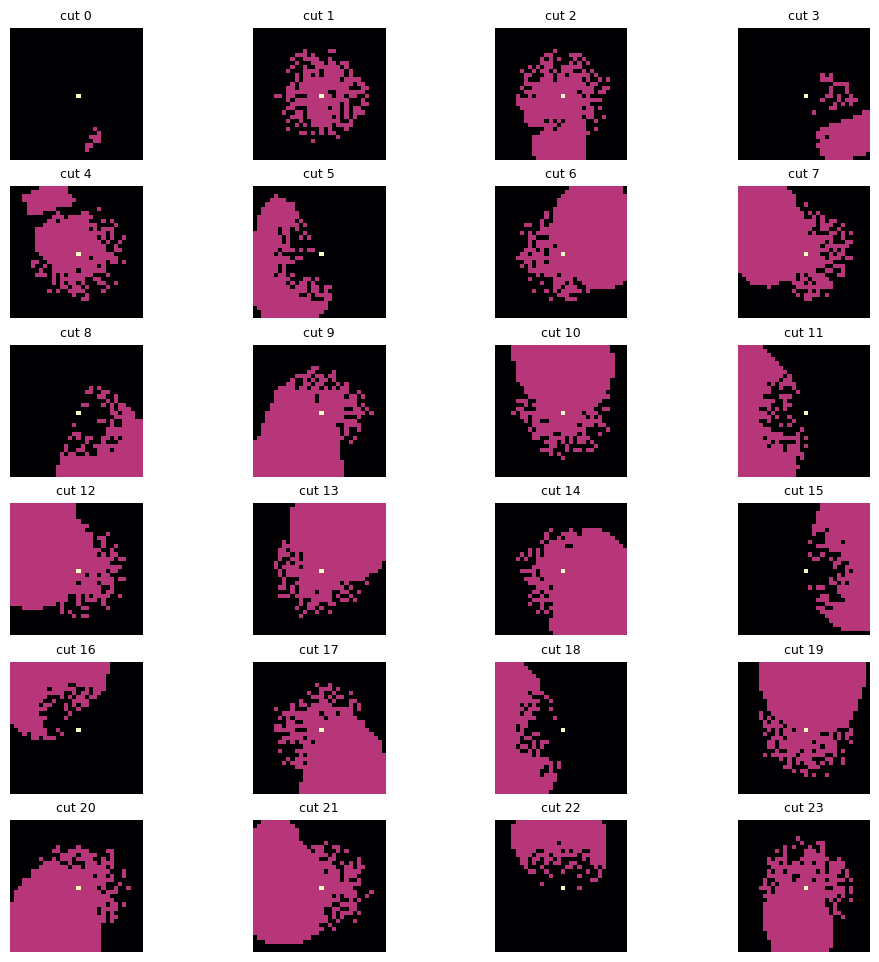

In [81]:
img, label = clicks_dataset[1]
cuts, clicks = cut_volume(label, cut_size=32, num=24)

plot_cuts(cuts)
plot_cuts(simulate_errors(cuts, cut_size=32, num=24))

#### 2nd try - morphological operations

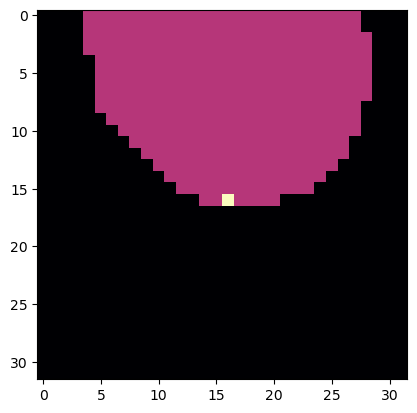

In [100]:
cuts, clicks = cut_volume(label, cut_size=32, num=24)
plot_cut(cuts[10])

In [186]:
def simulate_errors(cuts: list[torch.Tensor]) -> list[torch.Tensor]:
    # cuts, _ = cut_volume(label, cut_size=cut_size, num=num)
    erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(3, 3))
    dilatation_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(3, 3))

    faked_cuts = []
    for cut in cuts:
        pp = np.random.uniform(low=0.0, high=1.0)

        if 0.5 > pp:
            cut = cv2.erode(cut.numpy(), kernel=erosion_kernel, iterations=1)
        else:
            cut = cv2.dilate(cut.numpy(), kernel=dilatation_kernel, iterations=1)
        faked_cuts.append(torch.tensor(cut))

    return faked_cuts

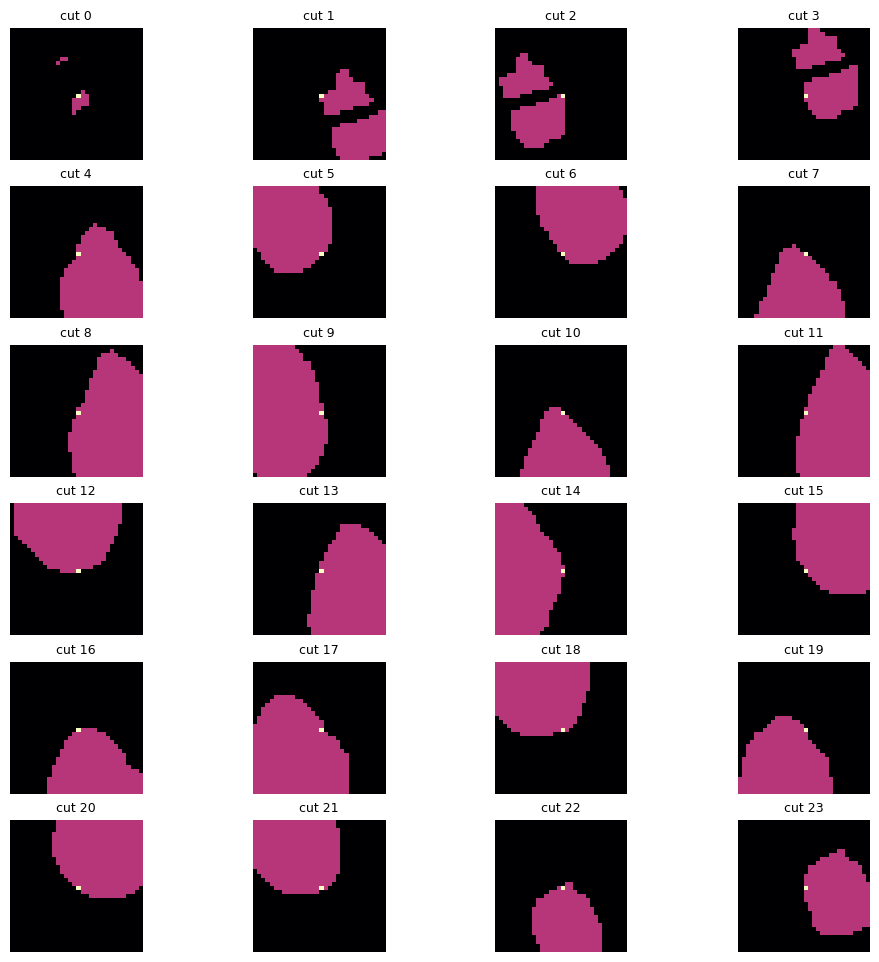

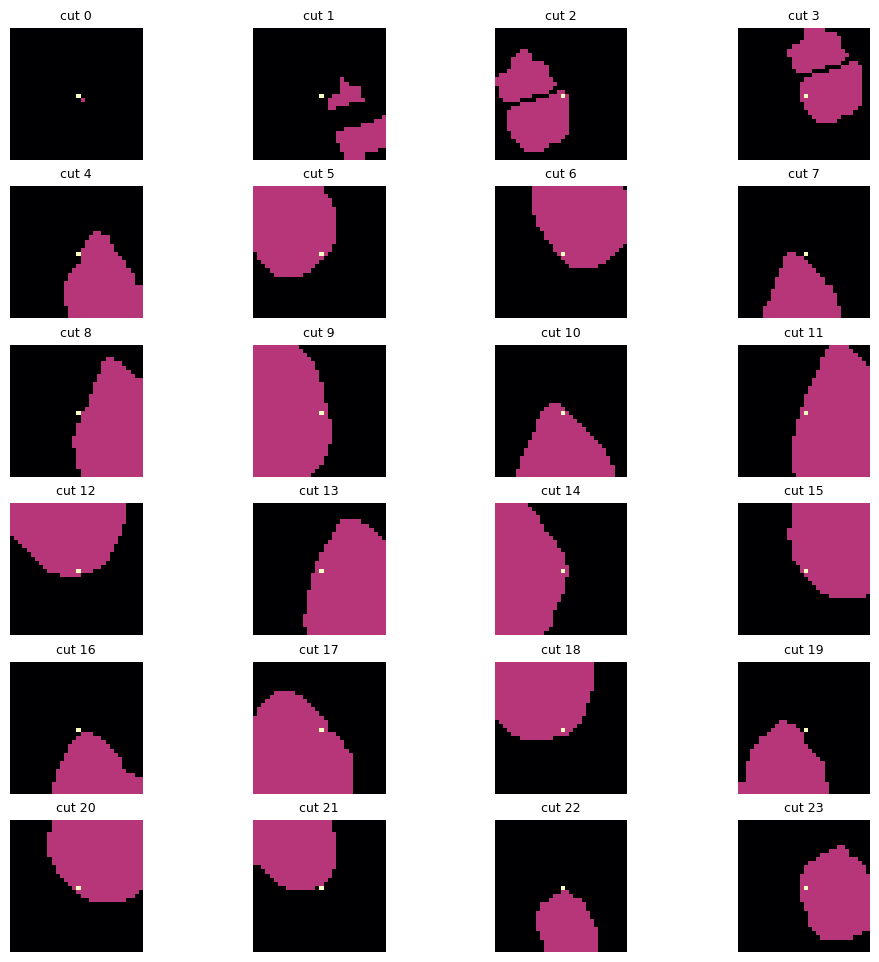

In [187]:
img, label = clicks_dataset[1]
cuts, clicks = cut_volume(label, cut_size=32, num=24)

plot_cuts(cuts)
plot_cuts(simulate_errors(cuts))

#### Using pre-trained model

In [21]:
from src.model import Unet
# from src.losses.dice import dice_coefficient

In [22]:
model = Unet(
    in_channels=2, 
    out_channels=1, 
    blocks=3
).to('cpu')

checkpoint = torch.load('../src/models/pretrained_dice_20.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [45]:
img, y = clicks_dataset[1]

model.eval()
with torch.no_grad():
    x = img.unsqueeze(0).to('cpu')
    y_pred = model(x)

In [46]:
y_pred.shape

torch.Size([1, 1, 40, 256, 256])

In [47]:
threshed_pred = torch.clone(y_pred)

In [73]:
threshed_pred[0,0][threshed_pred[0,0] < 0.6] = 0
threshed_pred[0,0][threshed_pred[0,0] >= 0.6] = 1

In [54]:
fig = px.imshow(threshed_pred[0,0,17])
fig.show()

In [139]:
# y_pred[0][y_pred[0] > 0.9] = 1
# plot_tumour(threshed_pred[0])

In [140]:
# plot_tumour(y)

In [127]:
pred_cuts, _ = cut_volume(torch.stack((threshed_pred[0,0], label[1])), 10, 24)

6


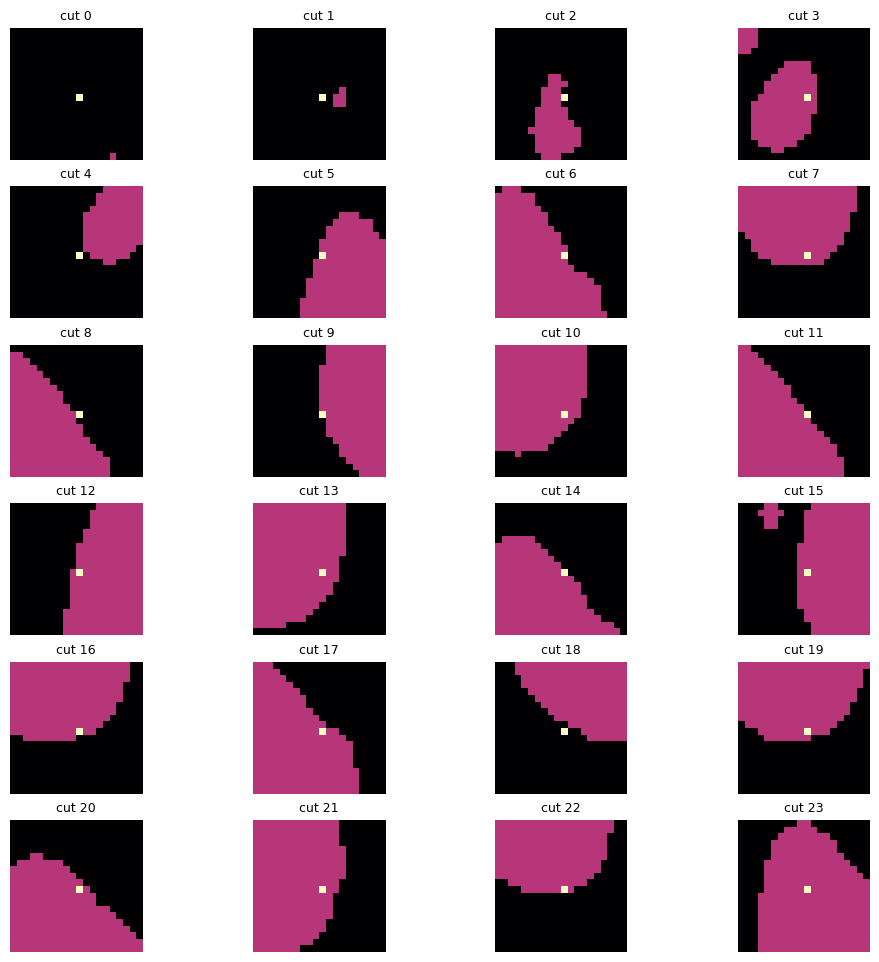

In [128]:
plot_cuts(pred_cuts)

6


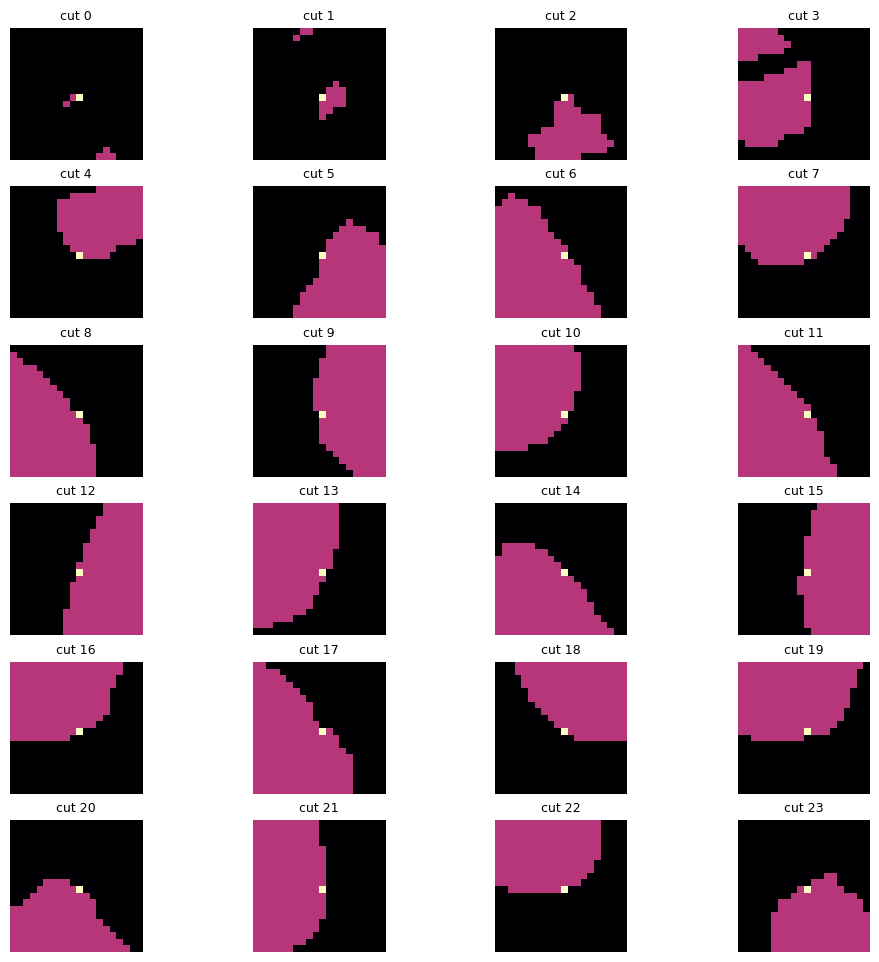

In [126]:
cc, _ = cut_volume(label, 10, 24)
plot_cuts(cc)

### Testing data generator

In [18]:
from src.data_generator import CorrectionMRIDataset, CorrectionDataloader

In [53]:
data = CorrectionMRIDataset(
    seg_list[:4], 
    (40, 256, 256),
    clicks = {
        'num': 3,
        'dst': 10
    },
    cuts = {
        'num': np.inf,
        'size': 32,
        'random': False,
    },
    errors=False
)
cuts = data[0]

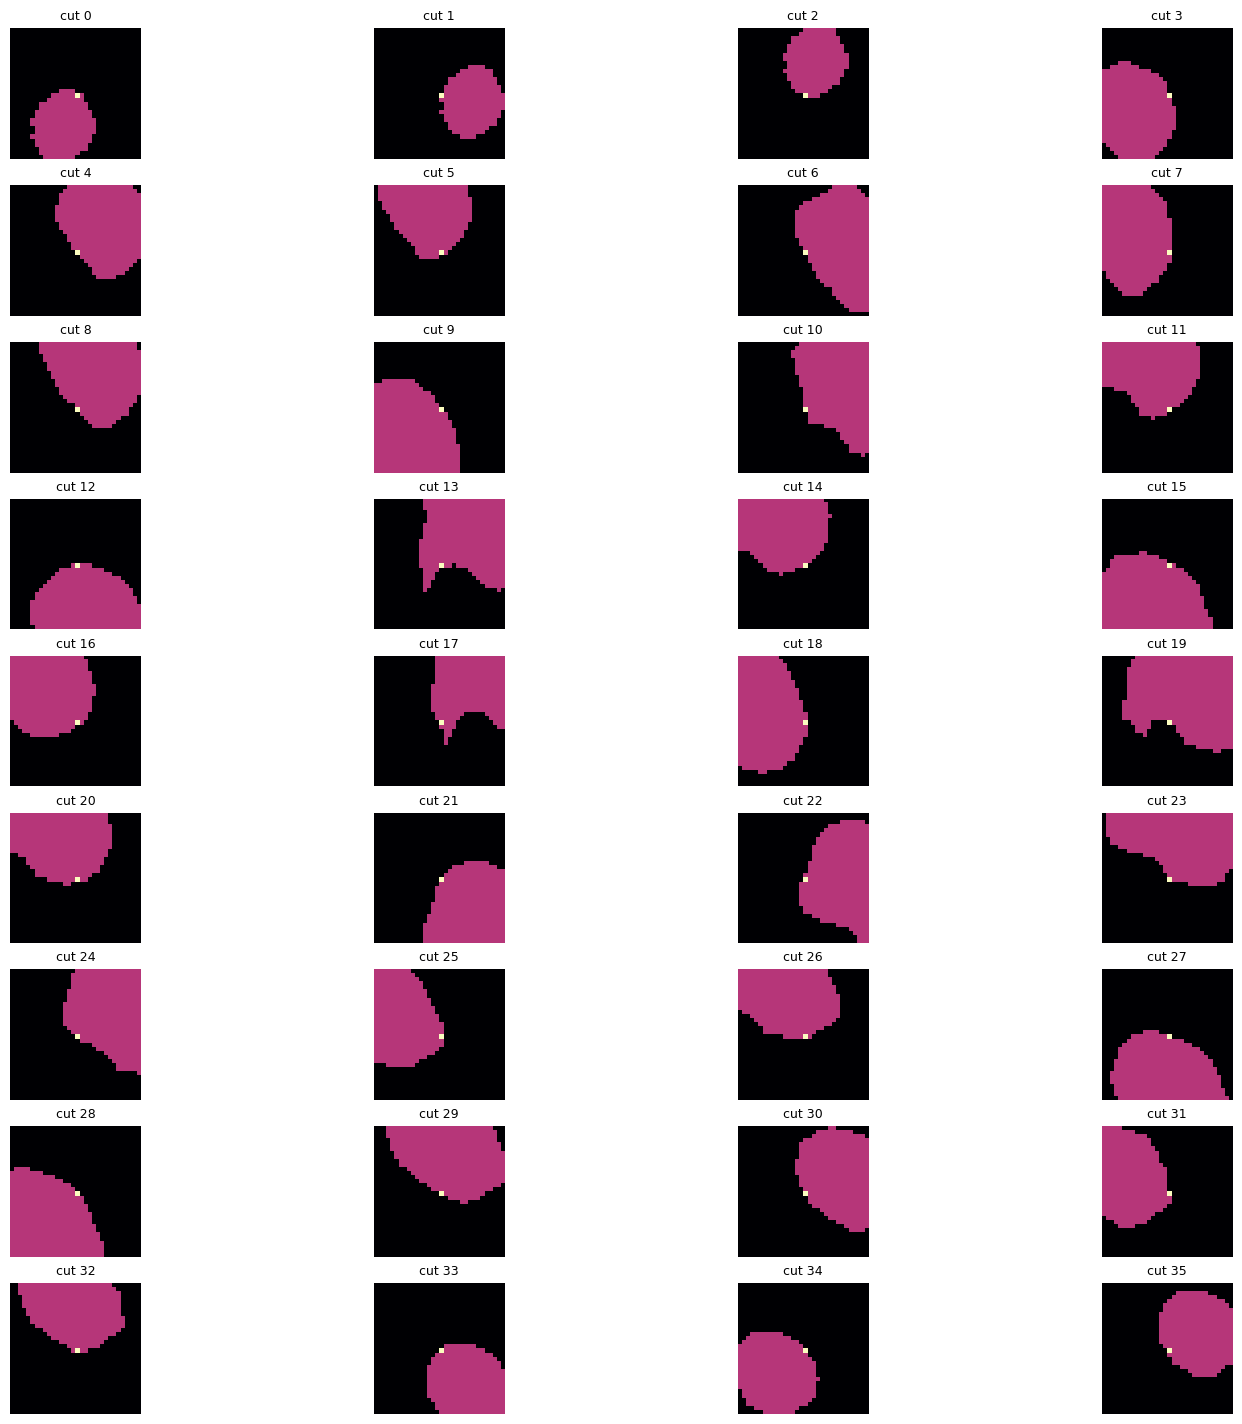

In [54]:
plot_cuts(cuts)

In [55]:
batch_size = 4
batches = [torch.stack(cuts[i:i+batch_size]) for i in range(0, len(cuts), batch_size)]

In [56]:
batches[0].shape

torch.Size([4, 1, 32, 32])

In [ ]:
batch_size = 4
for cuts in data:
    for i in range(0, len(cuts), batch_size):
        batch = torch.stack(cuts[i:i+batch_size])
        print(batch.shape)
    print('new seg')